In [16]:
import os

import torch
from clip_forge.networks.latent_flows import LatentFlows
from clip_forge.networks.autoencoder import Autoencoder
from clip_forge.dataset.datamodule import BuildingNetEmbeddingDataModule, get_clip_model
from clip_forge.utils.visualization import make_3d_grid, multiple_plot_voxel

import pytorch_lightning as pl
import wandb
from clip import tokenize

In [2]:
wandb.init()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: maxdumas. Use `wandb login --relogin` to force relogin


In [3]:
AUTOENCODER_CKPT_NAME = "maxdumas/clip_forge_autoencoder/model-g87d684q:v23"
LF_CKPT_NAME = "maxdumas/clip_forge_latent_flows/model-f1sc6ifs:v91"

In [4]:
checkpoint = wandb.use_artifact(AUTOENCODER_CKPT_NAME, "model")
checkpoint_dir = checkpoint.download()
checkpoint_path = os.path.join(checkpoint_dir, "model.ckpt")
print(f"Loading specified W&B autoencoder Checkpoint from {checkpoint_path}.")
autoencoder = Autoencoder.load_from_checkpoint(checkpoint_path)
autoencoder.eval()

checkpoint = wandb.use_artifact(LF_CKPT_NAME, "model")
checkpoint_dir = checkpoint.download()
checkpoint_path = os.path.join(checkpoint_dir, "model.ckpt")
print(f"Loading specified W&B latent flows Checkpoint from {checkpoint_path}.")
latent_flow_network = LatentFlows.load_from_checkpoint(checkpoint_path)
_ = latent_flow_network.eval()

wandb: Downloading large artifact model-g87d684q:v23, 80.17MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.2
/opt/homebrew/Caskroom/mambaforge/base/envs/clip_forge/lib/python3.9/site-packages/pytorch_lightning/utilities/migration/utils.py:49: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.0.2, which is newer than your current Lightning version: v2.0.1
  rank_zero_warn(


Loading specified W&B autoencoder Checkpoint from ./artifacts/model-g87d684q:v23/model.ckpt.


wandb: Downloading large artifact model-f1sc6ifs:v91, 240.39MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.5


Loading specified W&B latent flows Checkpoint from ./artifacts/model-f1sc6ifs:v91/model.ckpt.


LatentFlows(
  (generator): FlowSequential(
    (0): CouplingLayer(
      (scale_net): Sequential(
        (0): Linear(in_features=768, out_features=1024, bias=True)
        (1): Tanh()
        (2): Linear(in_features=1024, out_features=1024, bias=True)
        (3): Tanh()
        (4): Linear(in_features=1024, out_features=256, bias=True)
      )
      (translate_net): Sequential(
        (0): Linear(in_features=768, out_features=1024, bias=True)
        (1): ReLU()
        (2): Linear(in_features=1024, out_features=1024, bias=True)
        (3): ReLU()
        (4): Linear(in_features=1024, out_features=256, bias=True)
      )
    )
    (1): BatchNormFlow()
    (2): CouplingLayer(
      (scale_net): Sequential(
        (0): Linear(in_features=768, out_features=1024, bias=True)
        (1): Tanh()
        (2): Linear(in_features=1024, out_features=1024, bias=True)
        (3): Tanh()
        (4): Linear(in_features=1024, out_features=256, bias=True)
      )
      (translate_net): Sequent

In [6]:
clip, _, _ = get_clip_model("B-32", "cpu")

In [165]:
text = tokenize(["a round castle"])

In [166]:
text_embedding = clip.encode_text(text)
text_embedding = text_embedding / text_embedding.norm(dim=-1, keepdim=True)

In [167]:
noise = torch.Tensor(1, latent_flow_network.num_inputs).normal_()
decoder_embedding = latent_flow_network.sample(1, noise, text_embedding)

In [168]:
query_points = make_3d_grid([-0.5] * 3, [+0.5] * 3, (32, 32, 32), device=autoencoder.device)
out = autoencoder.net.decoder(query_points, decoder_embedding)

In [169]:
voxels = (out.view(1, 32, 32, 32) > 0.05).detach().numpy()

/var/folders/tc/1vt9ksq93ks834zj975w_xt00000gn/T/ipykernel_38026/1495795709.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  multiple_plot_voxel(voxels).show()


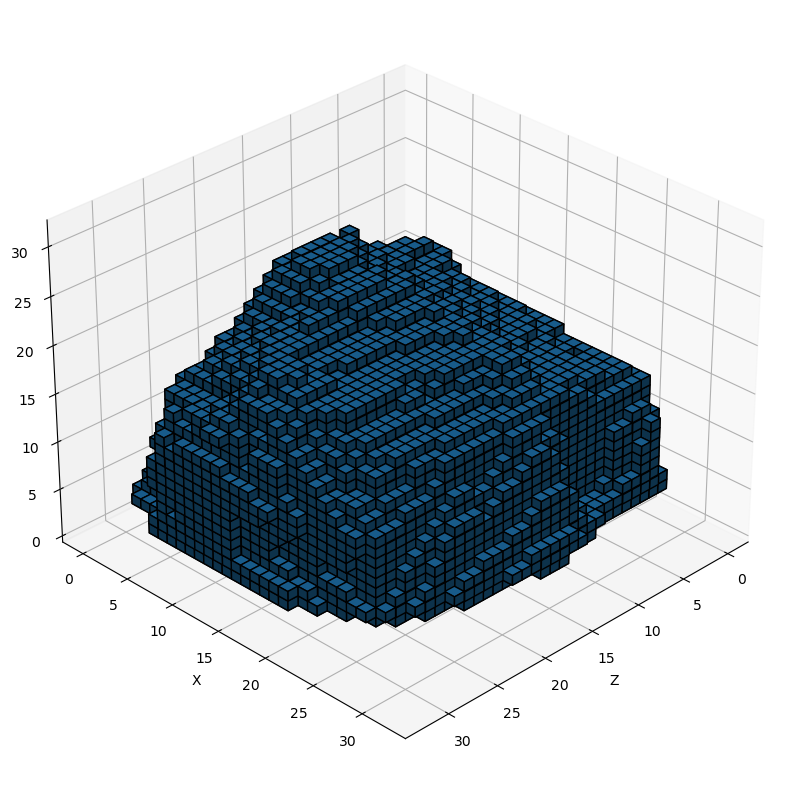

In [170]:
multiple_plot_voxel(voxels).show()